Tested on https://147.251.21.115/user/tinaok/lab/tree/foss4g-2022/wildfires

Cluster small?. Crash.

# Burn severity maps using Sentinel-2 Cloud-Optimised Dataset

:::{eval-rst}
:opticon:`tag`
:badge:`wildfires,badge-primary`
:badge:`Mapping,badge-secondary`
:::

## Context
### Purpose
Demonstrate how to fetch satellite Sentinel-2 data to generate burn severity maps for the assessment of the areas affected by wildfires.

### Methodology approach
* Access Sentinel-2 L2A cloud optimised dataset through STAC
* Compute the Normalised Burn Ratio (NBR) index to highlight burned areas
* Classify burn severity

### Highlights
* The NBR index uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths.

### Contributions
#### Notebook
Author (role), Affiliation, GitHub alias

#### Related publications
* https://www.sciencedirect.com/science/article/pii/S1470160X22004708#f0035
* https://github.com/yobimania/dea-notebooks/blob/e0ca59f437395f7c9becca74badcf8c49da6ee90/Fire%20Analysis%20Compiled%20Scripts%20(Gadi)/dNBR_full.py

:::{note}
*Optional: add credits or acknowledgements to data providers or authors of code snippets*
:::

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation e.g. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the notebooks. Don't remove them.*

In [1]:
!pip install odc-stac

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00


## Dask use 'Client' as well, thus pystac_client  is renamed


In [2]:
import os
#import dask.distributed

from pystac_client import Client as pystac_client
from odc.stac import configure_rio, stac_load
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

# Dask Local client test


In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster

## copy and past 'Dashboard link' to Dask lab extension.
From Dask extension,you can open Task Stream, Graph, Progress, Workers ...

at EGI_ACE configuration, today it would be 'http://127.0.0.1:8787/'


## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Change `<replace-by-notebook-filename>` with your notebook identifier.*

In [4]:
notebook_folder = './wildfires-foss4g'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Load data
*Load full dataset from original or mirror sources. If the license of the dataset permits, we suggest creating sample data (preprocessed) for the notebook stored in a data repository e.g. Zenodo.*

In [5]:
index_name = 'NBR'

bandnames_dict = {
    'B08': 'nir',
    'B12': 'swir2'
}

km2deg = 1.0 / 111
x, y = (23.9983519, 37.7351433)  # Center point of a query
r = 4 * km2deg  
bbox = (x - r, y - r, x + r, y + r)
zoom = 1

crs = "epsg:3857"  # projection on which the data will be projected

# Normalised Burn Ratio, Lopez Garcia 1991
index_dict = {'NBR': lambda ds: (ds.nir - ds.swir2) / (ds.nir + ds.swir2)}
index_dict

{'NBR': <function __main__.<lambda>(ds)>}

## Show location on a map

Text(0.5, 1.0, 'Map of the area of interest')

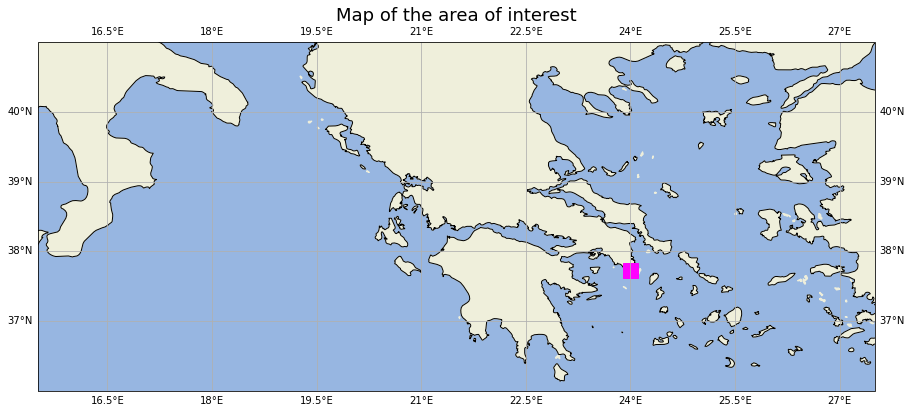

In [6]:
fig = plt.figure(1, figsize=[15, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([15.5, 27.5, 36, 41], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

plt.plot(x, y,
         color='magenta', markersize=15, marker='s',
         transform=ccrs.PlateCarree(),
         )

# One way to customize your title
plt.title("Map of the area of interest", fontsize=18)

## Open Catalog and get data

***DASK UPDATE***

In [7]:
# Open a catalog
#catalog = Client.open("https://earth-search.aws.element84.com/v0")

catalog = pystac_client.open("https://earth-search.aws.element84.com/v0")



## Increase computation and try Dask

In [8]:
zoom=1 #/2
chunk={"y":100}

## Search and get data before the fire
- time_range contains the period over which data will be searched;
- query contains additional requirements e.g. get data only when the cloud cover is low (< 0.5)

In [9]:
# prefire data
time_range = "2021-08-10/2021-08-16"

query1 = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}},
)

items = list(query1.get_items())
print(f"Found: {len(items):d} datasets")

items_pre = min(items, key=lambda item: item.properties["eo:cloud_cover"])

prefire_ds = stac_load(
    [items_pre],
    bands=("B08", "B12"),
    crs=crs,
    resolution=  10*zoom,
    chunks=chunk,  # <-- use Dask
    groupby="datetime",
    bbox=bbox,
)
prefire_ds

Found: 2 datasets


<xarray.Dataset>
Dimensions:      (y: 1016, x: 803, time: 1)
Coordinates:
  * y            (y) float64 4.547e+06 4.547e+06 ... 4.537e+06 4.537e+06
  * x            (x) float64 2.667e+06 2.667e+06 ... 2.675e+06 2.675e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-08-13T09:20:08
Data variables:
    B08          (time, y, x) float32 dask.array<chunksize=(1, 100, 803), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 100, 803), meta=np.ndarray>

## Search and get data after the fire

In [10]:
##postfire
time_range = "2021-08-17/2021-08-20"

query2 = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}},
)

items = list(query2.get_items())
print(f"Found: {len(items):d} datasets")

items_post = min(items, key=lambda item: item.properties["eo:cloud_cover"])

postfire_ds = stac_load(
    [items_post],
    bands=("B08", "B12"),
    crs=crs,
    resolution=10 * zoom,
    chunks=chunk,  # <-- use Dask
    groupby="datetime",
    bbox=bbox,
)
postfire_ds

Found: 2 datasets


<xarray.Dataset>
Dimensions:      (y: 1016, x: 803, time: 1)
Coordinates:
  * y            (y) float64 4.547e+06 4.547e+06 ... 4.537e+06 4.537e+06
  * x            (x) float64 2.667e+06 2.667e+06 ... 2.675e+06 2.675e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-08-18T09:20:05
Data variables:
    B08          (time, y, x) float32 dask.array<chunksize=(1, 100, 803), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 100, 803), meta=np.ndarray>

## Methodology
*Add code demonstrating the methodology.*

In [11]:
# Rename bands in dataset to use simple names 
bands_to_rename = {
    a: b for a, b in bandnames_dict.items() if a in prefire_ds.variables
}

# prefire
prefire_ds[index_name] = index_dict[index_name](prefire_ds.rename(bands_to_rename) / 10000.0)

# postfire
postfire_ds[index_name] = index_dict[index_name](postfire_ds.rename(bands_to_rename) / 10000.0)


In [12]:
# calculate delta NBR
prefire_burnratio = prefire_ds.NBR.isel(time=0)
postfire_burnratio = postfire_ds.NBR.isel(time=0)

delta_NBR = prefire_burnratio - postfire_burnratio

dnbr_dataset = delta_NBR.to_dataset(name='delta_NBR')

## Outputs
*Provide a brief inspection of the methodology outputs and their interpretation*

In [13]:
dnbr_dataset
delta_NBR

<xarray.DataArray 'NBR' (y: 1016, x: 803)>
dask.array<sub, shape=(1016, 803), dtype=float32, chunksize=(100, 803), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.547e+06 4.547e+06 ... 4.537e+06 4.537e+06
  * x            (x) float64 2.667e+06 2.667e+06 ... 2.675e+06 2.675e+06
    spatial_ref  int32 3857

## Zoom on the area

* DASK 'lazy' computation starts here.  Watchout the Task Stream and Worker CPU usage for following 3 plots!! 

In [ ]:
fig = plt.figure(1, figsize=[7, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
prefire_burnratio.plot(ax=ax, transform=ccrs.epsg(prefire_burnratio.spatial_ref.values), cmap='RdBu_r',
                       cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( pd.to_datetime(prefire_burnratio.time.values.item()).strftime("%d %B %Y"), fontsize=18)

In [ ]:
fig = plt.figure(1, figsize=[7, 9])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
postfire_burnratio.plot(ax=ax, transform=ccrs.epsg(postfire_burnratio.spatial_ref.values), cmap='RdBu_r',
                        cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( pd.to_datetime(postfire_burnratio.time.values.item()).strftime("%d %B %Y"), fontsize=18)

In [ ]:
fig = plt.figure(1, figsize=[7, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
dnbr_dataset.delta_NBR.plot(ax=ax, transform=ccrs.epsg(dnbr_dataset.delta_NBR.spatial_ref.values), cmap='RdBu_r',
                            cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( "Delta NBR", fontsize=18)

## Summary
*Provide 3-5 bullet points summarising the main aspects of the pre-processing and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information

**License**: The code in this notebook is licensed under the MIT License.

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue]() or send a direct message to [](mailto:xxx@gmail.com).

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')